In [1]:
# !pip install git+https://github.com/qubvel/segmentation_models

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator

MASK_COLORS = [
    "red", "green", "blue",
    "yellow", "magenta", "cyan"
]


# Runtime data augmentation
def get_augmented(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    s=10,
    data_gen_args=dict(
        rotation_range=10.0,
        # width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        # zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="constant",
    ),
):
    """[summary]
    
    Args:
        X_train (numpy.ndarray): [description]
        Y_train (numpy.ndarray): [description]
        X_val (numpy.ndarray, optional): [description]. Defaults to None.
        Y_val (numpy.ndarray, optional): [description]. Defaults to None.
        batch_size (int, optional): [description]. Defaults to 32.
        seed (int, optional): [description]. Defaults to 0.
        data_gen_args ([type], optional): [description]. Defaults to dict(rotation_range=10.0,# width_shift_range=0.02,height_shift_range=0.02,shear_range=5,# zoom_range=0.3,horizontal_flip=True,vertical_flip=False,fill_mode="constant",).
    
    Returns:
        [type]: [description]
    """

    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=s)
    Y_datagen.fit(Y_train, augment=True, seed=s)
    X_train_augmented = X_datagen.flow(
        X_train, batch_size=batch_size, shuffle=True, seed=s
    )
    Y_train_augmented = Y_datagen.flow(
        Y_train, batch_size=batch_size, shuffle=True, seed=s
    )

    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=False, seed=s)
        Y_datagen_val.fit(Y_val, augment=False, seed=s)
        X_val_augmented = X_datagen_val.flow(
            X_val, batch_size=batch_size, shuffle=False, seed=s
        )
        Y_val_augmented = Y_datagen_val.flow(
            Y_val, batch_size=batch_size, shuffle=False, seed=s
        )

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)

        return train_generator, val_generator
    else:
        return train_generator


def plot_segm_history(history, metrics=["iou", "val_iou"], losses=["loss", "val_loss"]):
    """[summary]
    
    Args:
        history ([type]): [description]
        metrics (list, optional): [description]. Defaults to ["iou", "val_iou"].
        losses (list, optional): [description]. Defaults to ["loss", "val_loss"].
    """
    # summarize history for iou
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()


def mask_to_red(mask):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    
    Args:
        mask (numpy.ndarray): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    img_size = mask.shape[0]
    c1 = mask.reshape(img_size, img_size)
    c2 = np.zeros((img_size, img_size))
    c3 = np.zeros((img_size, img_size))
    c4 = mask.reshape(img_size, img_size)
    return np.stack((c1, c2, c3, c4), axis=-1)


def mask_to_rgba(mask, color="red"):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    
    Args:
        mask (numpy.ndarray): [description]
        color (str, optional): Check `MASK_COLORS` for available colors. Defaults to "red".
    
    Returns:
        numpy.ndarray: [description]
    """    
    assert(color in MASK_COLORS)
    assert(mask.ndim==3 or mask.ndim==2)

    h = mask.shape[0]
    w = mask.shape[1]
    zeros = np.zeros((h, w))
    ones = mask.reshape(h, w)
    if color == "red":
        return np.stack((ones, zeros, zeros, ones), axis=-1)
    elif color == "green":
        return np.stack((zeros, ones, zeros, ones), axis=-1)
    elif color == "blue":
        return np.stack((zeros, zeros, ones, ones), axis=-1)
    elif color == "yellow":
        return np.stack((ones, ones, zeros, ones), axis=-1)
    elif color == "magenta":
        return np.stack((ones, zeros, ones, ones), axis=-1)
    elif color == "cyan":
        return np.stack((zeros, ones, ones, ones), axis=-1)


def plot_imgs(
        org_imgs,
        mask_imgs,
        pred_imgs=None,
        nm_img_to_plot=10,
        figsize=4,
        alpha=0.5,
        color="red"):
    """
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    Args:
        org_imgs (numpy.ndarray): Array of arrays representing a collection of original images.
        mask_imgs (numpy.ndarray): Array of arrays representing a collection of mask images (grayscale).
        pred_imgs (numpy.ndarray, optional): Array of arrays representing a collection of prediction masks images.. Defaults to None.
        nm_img_to_plot (int, optional): How many images to display. Takes first N images. Defaults to 10.
        figsize (int, optional): Matplotlib figsize. Defaults to 4.
        alpha (float, optional): Transparency for mask overlay on original image. Defaults to 0.5.
        color (str, optional): Color for mask overlay. Defaults to "red".
    """ # NOQA E501
    assert(color in MASK_COLORS)

    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

    fig, axes = plt.subplots(
        nm_img_to_plot, cols, figsize=(cols * figsize, nm_img_to_plot * figsize), squeeze=False
    )
    axes[0, 0].set_title("original", fontsize=15)
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15)
        axes[0, 3].set_title("overlay", fontsize=15)
    else:
        axes[0, 2].set_title("overlay", fontsize=15)
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(
                mask_to_rgba(
                    zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(pred_imgs),
                alpha=alpha,
            )
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(
                mask_to_rgba(
                    zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(mask_imgs),
                alpha=alpha,
            )
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()


def zero_pad_mask(mask, desired_size):
    """[summary]
    
    Args:
        mask (numpy.ndarray): [description]
        desired_size ([type]): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")
    return padded_mask


def reshape_arr(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])


def get_cmap(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        string: [description]
    """
    if arr.ndim == 3:
        return "gray"
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return "jet"
        elif arr.shape[3] == 1:
            return "gray"


def get_patches(img_arr, size=256, stride=256):
    """
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    
    Args:
        img_arr (numpy.ndarray): [description]
        size (int, optional): [description]. Defaults to 256.
        stride (int, optional): [description]. Defaults to 256.
    
    Raises:
        ValueError: [description]
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """    
    # check size and stride
    if size % stride != 0:
        raise ValueError("size % stride must be equal 0")

    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride - overlapping

        for i in range(i_max):
            for j in range(i_max):
                # print(i*stride, i*stride+size)
                # print(j*stride, j*stride+size)
                patches_list.append(
                    img_arr[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size
                    ]
                )

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    # print(i*stride, i*stride+size)
                    # print(j*stride, j*stride+size)
                    patches_list.append(
                        im[
                            i * stride : i * stride + size,
                            j * stride : j * stride + size,
                        ]
                    )

    else:
        raise ValueError("img_arr.ndim must be equal 3 or 4")

    return np.stack(patches_list)


def plot_patches(img_arr, org_img_size, stride=None, size=None):
    """
    Plots all the patches for the first image in 'img_arr' trying to reconstruct the original image
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    Raises:
        ValueError: [description]
    """

    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    fig, axes = plt.subplots(i_max, j_max, figsize=(i_max * 2, j_max * 2))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    jj = 0
    for i in range(i_max):
        for j in range(j_max):
            axes[i, j].imshow(img_arr[jj])
            axes[i, j].set_axis_off()
            jj += 1


def reconstruct_from_patches(img_arr, org_img_size, stride=None, size=None):
    """[summary]
    
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    
    Raises:
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    nm_layers = img_arr.shape[3]

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    total_nm_images = img_arr.shape[0] // (i_max ** 2)
    nm_images = img_arr.shape[0]

    averaging_value = size // stride
    images_list = []
    kk = 0
    for img_count in range(total_nm_images):
        img_bg = np.zeros(
            (org_img_size[0], org_img_size[1], nm_layers), dtype=img_arr[0].dtype
        )

        for i in range(i_max):
            for j in range(j_max):
                for layer in range(nm_layers):
                    img_bg[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size,
                        layer,
                    ] = img_arr[kk, :, :, layer]

                kk += 1
        # TODO add averaging for masks - right now it's just overwritting

        #         for layer in range(nm_layers):
        #             # average some more because overlapping 4 patches
        #             img_bg[stride:i_max*stride, stride:i_max*stride, layer] //= averaging_value
        #             # corners:
        #             img_bg[0:stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value
        #             img_bg[0:stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value

        images_list.append(img_bg)

    return np.stack(images_list)

2023-08-30 13:24:06.790487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 13:24:10.470840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### dicom_reader.py

In [2]:
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def apply_window(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_width, window_level):
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = apply_window(image_hu.copy(), window_level, window_width)
    image_window_norm = resize_normalize(image_window)

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    return image_ths

# EDA

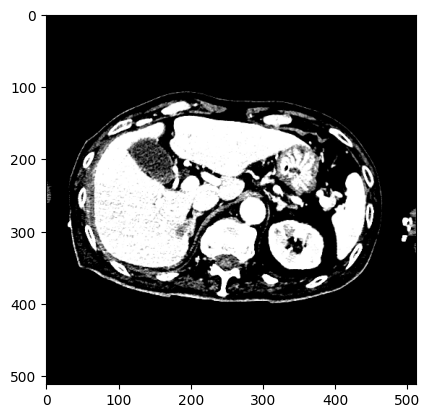

In [23]:
import matplotlib.pyplot as plt

# specify your image path
image_path = "./train/dcm/case001.dcm"
im = read_dicom(image_path, 100, 50)
%matplotlib inline
imgplot = plt.imshow(im)
plt.show()

(array([575385.,  10962.,  11985.,   9336.,   9585.,   9096.,   6900.,
          5823.,   8037., 139323.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

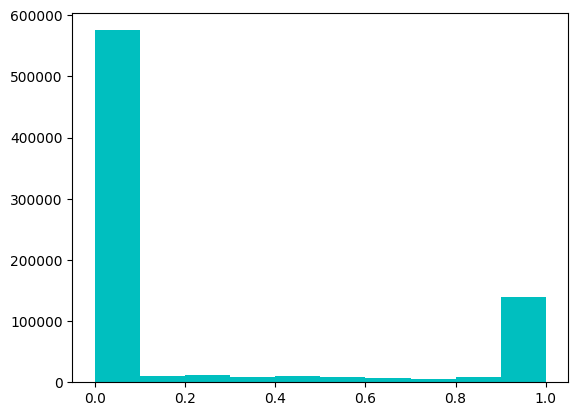

In [24]:
plt.hist(im.flatten(), color='c')

In [25]:
np.unique(im)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [26]:
import cv2
import pydicom
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [29]:
im = mpimg.imread("./train/label/case003.png")
unique, counts = np.unique(im, return_counts=True)
dict(zip(unique, counts))

{0.0: 159566, 0.003921569: 72640, 0.007843138: 15781, 0.011764706: 14157}

In [30]:
np.unique(im)

array([0.        , 0.00392157, 0.00784314, 0.01176471], dtype=float32)

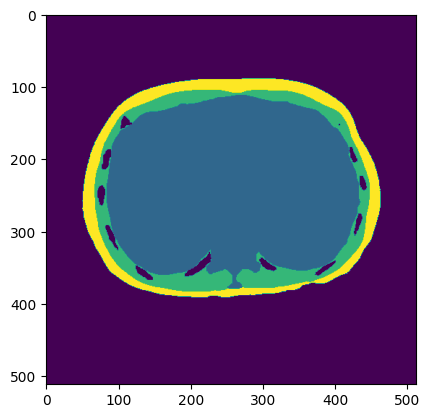

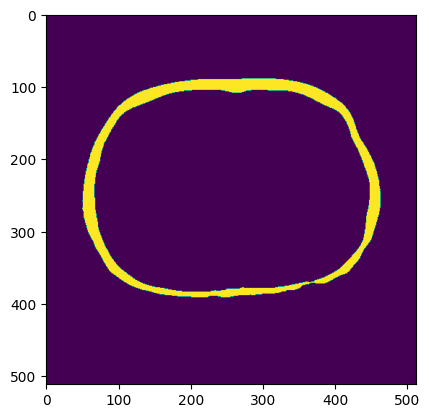

In [33]:
im = mpimg.imread("./train/label/case003.png")
im = np.around(im, 8)
mask_1 = im <= np.around(0.007843138, 8)
mask_2 = im >= np.around(0.011764706, 8)

mask_3 = np.logical_and(mask_1, mask_2)
mask_3
# im = np.expand_dims(im, axis=-1)
%matplotlib inline
imgplot = plt.imshow(im)
plt.show()
mask_3_int = mask_2.astype(float)
imgplot = plt.imshow(mask_3_int)
plt.show()

In [34]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH_IMAGE = './train/dcm/'
TRAIN_PATH_MASKS = './train/label/'
TEST_PATH = './test/dcm/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [87]:
# Get train and test IDs
train_ids = [f for f in sorted(os.listdir(TRAIN_PATH_IMAGE)) if os.path.isfile(os.path.join(TRAIN_PATH_IMAGE, f))]
test_ids = [f for f in sorted(os.listdir(TEST_PATH)) if os.path.isfile(os.path.join(TEST_PATH, f))]

In [36]:
def get_mask_innest(mask):
    mask_1 = mask < 0.007843138
    mask_2 = mask >= 0.003921569
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_3.astype(float)
    return mask_3_int

def get_mask_middle(mask):
    mask_1 = mask < 0.011764706
    mask_2 = mask >= 0.007843138
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_3.astype(float)
    return mask_3_int

def get_mask_outtest(mask):
    mask_1 = mask < 0.011764706
    mask_2 = mask >= 0.011764706
    mask_3 = np.logical_and(mask_1, mask_2)
    mask_3_int = mask_2.astype(float)
    return mask_3_int
# {0.0: 159566, 0.003921569: 72640, 0.007843138: 15781, 0.011764706: 14157}

In [37]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
print('Getting and resizing train images and masks')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    if id_ == 'case001.dcm':
        print(n)
    path = TRAIN_PATH_IMAGE + id_
    img = read_dicom(path, 100, 50)
    X_train[n] = img
    mask_path = TRAIN_PATH_MASKS + id_.replace('dcm', 'png')
    mask = mpimg.imread(mask_path)
    mask = np.around(mask, 8)

    m_in = get_mask_innest(mask)
    m_md = get_mask_middle(mask)
    m_ot = get_mask_outtest(mask)
    
    m_in = np.expand_dims(m_in, axis=-1)
    m_md = np.expand_dims(m_md, axis=-1)
    m_ot = np.expand_dims(m_ot, axis=-1)
    
    m_fn = np.concatenate([m_in, m_md, m_ot], axis=-1)
    
    Y_train[n] = m_fn

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = read_dicom(path, 100, 50)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks


  3%|▎         | 3/100 [00:00<00:04, 24.05it/s]

0


100%|██████████| 100/100 [00:03<00:00, 33.26it/s]

Getting and resizing test images ... 



100%|██████████| 50/50 [00:00<00:00, 74.48it/s]

Done!


In [38]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (90, 512, 512, 3)
y_train:  (90, 512, 512, 3)
x_val:  (10, 512, 512, 3)
y_val:  (10, 512, 512, 3)


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


model_filename = 'segm_model_eff_b5.h5'

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, mode='max',
                              patience=20, min_lr= 1e-8)

# callback_checkpoint = ModelCheckpoint(
#     model_filename, 
#     verbose=1, 
#     monitor='val_iou', 
#     mode = 'max',
#     save_best_only=True,
# )

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_iou', patience=50, mode='max'
# )
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_dice_coef', 
    mode = 'max',
    save_best_only=True,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef', patience=50, mode='max'
)

### Loss function

In [41]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

### Model

In [42]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

BACKBONE = 'efficientnetb5'
preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet', classes=3)
model.summary()

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


2023-08-30 14:35:13.115248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10516 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 48)       1296      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 48)       192       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 48)       0         ['stem_bn[0][0]']         

In [43]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [44]:
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-08-30 14:35:21.871180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 10516 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


True

In [29]:
from tensorflow.keras.optimizers import AdamW, SGD

model.compile(
    optimizer=AdamW(learning_rate=1e-3), 
    loss=bce_logdice_loss,
    metrics=[dice_coef]
)

In [22]:
# model.load_weights("model_filename")

In [30]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

### Training

In [31]:
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=500,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint, reduce_lr, early_stop]
)

Epoch 1/500


2023-08-23 20:10:37.123500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - ETA: 0s - loss: 0.0843 - dice_coef: 0.9635
Epoch 1: val_dice_coef did not improve from 0.97303
50/50 [==============================] - 120s 421ms/step - loss: 0.0843 - dice_coef: 0.9635 - val_loss: 1.3016 - val_dice_coef: 0.7067 - lr: 0.0010
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.0837 - dice_coef: 0.9621
Epoch 2: val_dice_coef did not improve from 0.97303
50/50 [==============================] - 17s 340ms/step - loss: 0.0837 - dice_coef: 0.9621 - val_loss: 0.1526 - val_dice_coef: 0.9449 - lr: 0.0010
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.0912 - dice_coef: 0.9600
Epoch 3: val_dice_coef did not improve from 0.97303
50/50 [==============================] - 17s 337ms/step - loss: 0.0912 - dice_coef: 0.9600 - val_loss: 0.1133 - val_dice_coef: 0.9509 - lr: 0.0010
Epoch 4/500
50/50 [==============================] - ETA: 0s - loss: 0.0987 - dice_coef: 0.9561
Epoch 4: val_dice_coef did not

In [ ]:
# model.save(model_filename)

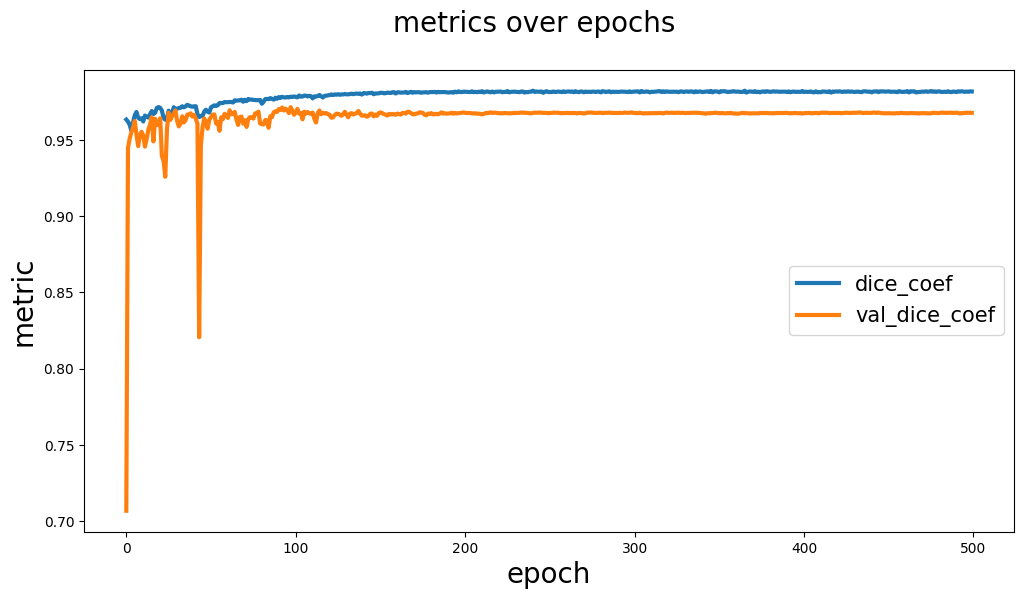

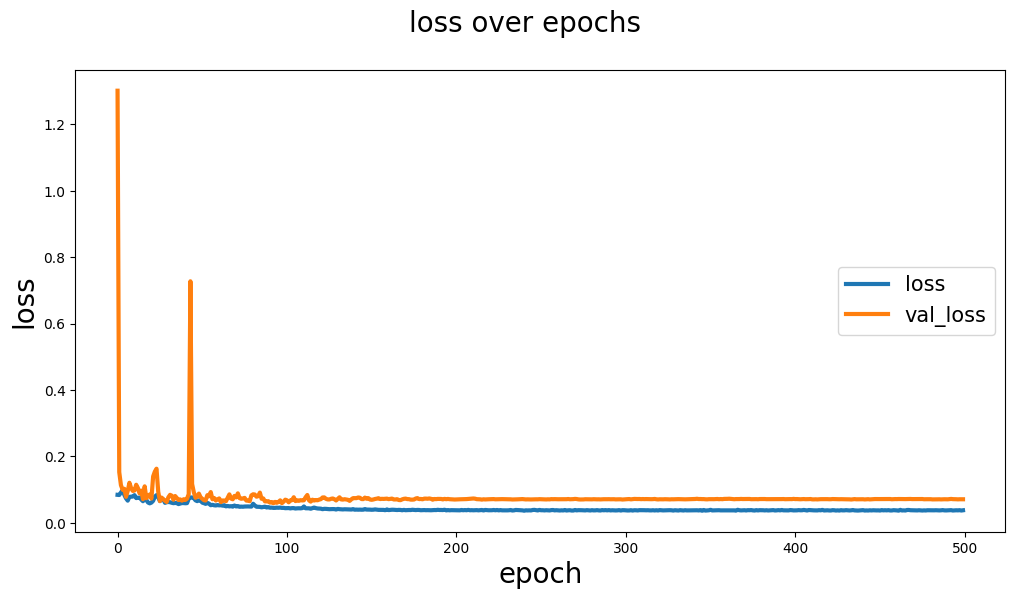

In [32]:
# from tensorflow.keras_unet.utils import plot_segm_history

plot_segm_history(history, metrics=["dice_coef", "val_dice_coef"])

In [144]:
model.load_weights("models/"+model_filename)
preds_test = np.zeros_like(X_test)
for i in range(50):
    inp = X_test[i,:,:,:]
    out = model.predict(np.expand_dims(inp, axis=0))
    preds_test[i,:,:,:] = out
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 44ms/step


### Post Processing

In [118]:
# # postprocessing code makes some error on data like X_train and X_test.
# def postprocessing(mask):
#     (thresh, blackAndWhiteImage) = cv2.threshold(np.uint8(mask*255), 127, 255, cv2.THRESH_BINARY)
#     im_floodfill = blackAndWhiteImage.copy()

#     h, w = blackAndWhiteImage.shape[:2]
#     mask = np.zeros((h+2, w+2), np.uint8)

#     cv2.floodFill(im_floodfill, mask, (0,0), 255);

#     im_floodfill_inv = cv2.bitwise_not(im_floodfill)

#     im_out = blackAndWhiteImage | im_floodfill_inv
    
#     return np.float32(im_out/255.0)

def remove_small_cts(img):
    img = np.uint8(img*255)
#     print(dtype(img))
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 5000:
            cv2.drawContours(img, [c], -1, (0,0,0), -1)
    return np.float32(img/255.0)

1/1 [==============================] - 0s 55ms/step


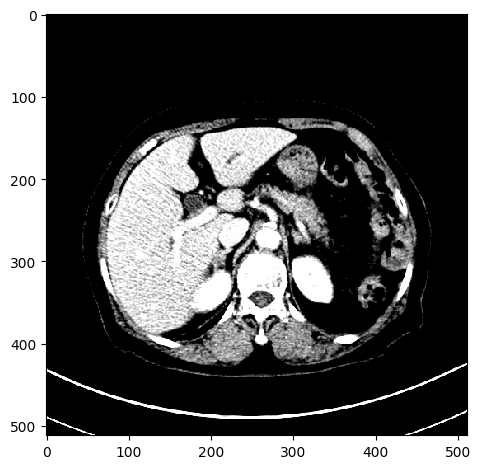

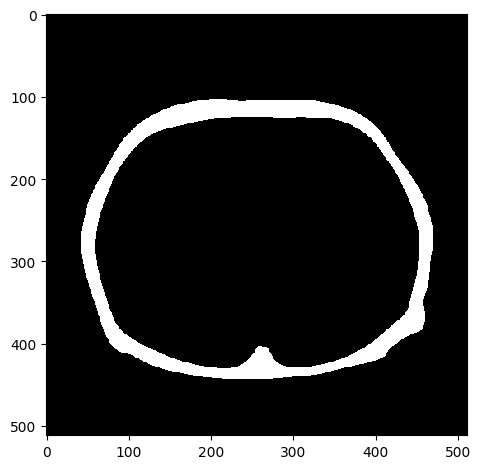

In [126]:
ix = 43
path = TEST_PATH + test_ids[ix]
img = read_dicom(path, 160, 50)
img.shape
out = model.predict(np.expand_dims(img, axis=0))
out[out > 0.5] = 1.0
out[out < 0.5] = 0.0
imshow(img)
plt.show()

imshow(out[0,:,:,2])
plt.show()

In [50]:
# ix = 43
# path = TEST_PATH + test_ids[ix]
# img = read_dicom(path, 350, 50)

# out = model.predict(np.expand_dims(img, axis=0))
# out[out > 0.5] = 1.0
# out[out < 0.5] = 0.0

# preds_test_t[ix,:,:,0] = out[0,:,:,0]

In [120]:
# i1 = preds_test_t[ix,:,:,0]
# i2 = preds_test_t[ix,:,:,1]
# i3 = preds_test_t[ix,:,:,2]

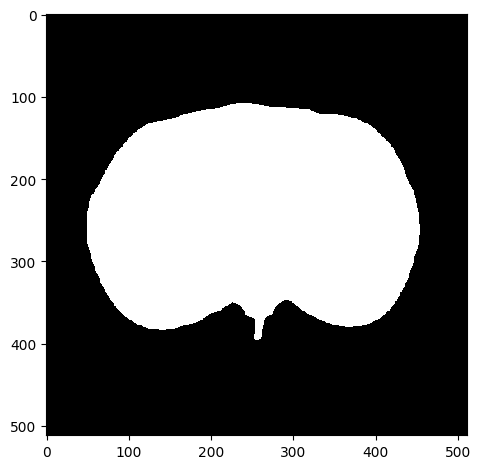

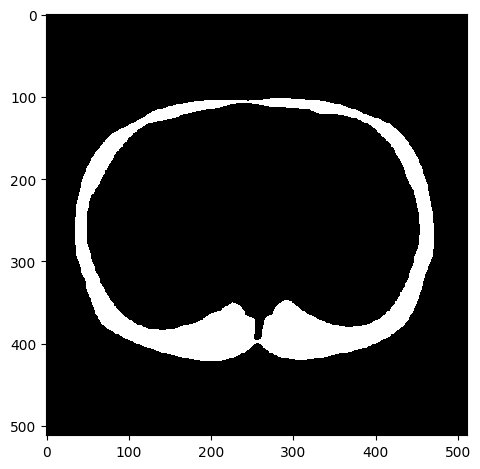

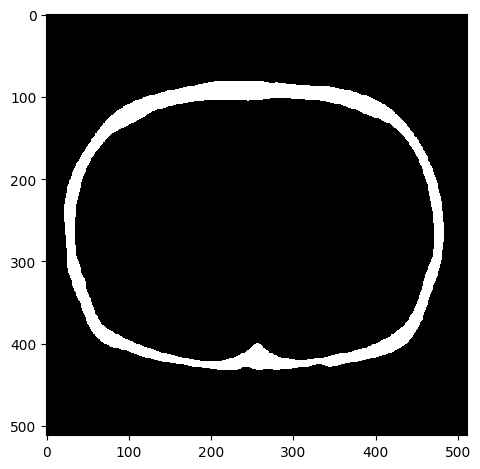

In [121]:
# # imshow(np.squeeze(np.float32(preds_test_t[ix, :, :, 2])))
# # plt.show()

# i1 = postprocessing(i1)
# i2 = postprocessing(i2)
# i3 = postprocessing(i3)

# i2[i1>0.5]=0
# i3[i1>0.5]=0
# i3[i2>0.5]=0

# imshow(np.squeeze(i1))
# plt.show()

# imshow(np.squeeze(i2))
# plt.show()

# imshow(np.squeeze(i3))
# plt.show()

In [40]:
# preds_test_t[ix,:,:,0] = i1
# preds_test_t[ix,:,:,1] = i2
# preds_test_t[ix,:,:,2] = i3

In [66]:
def remove_small_cts(img):
    img = np.uint8(img*255)
#     print(dtype(img))
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 3000:
            cv2.drawContours(img, [c], -1, (0,0,0), -1)
    return np.float32(img/255.0)

### rle_encode.py

In [72]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python\
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_encode_(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def my_encode(mask):
    x = np.zeros((mask.shape[0], mask.shape[1], 1))
    x[mask[:,:,0] > 0.5] = 1
    x[mask[:,:,1] > 0.5] = 2
    x[mask[:,:,2] > 0.5] = 3
    
    return x

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    encoded = my_encode(lab_img)
    imshow(np.squeeze(np.float32(encoded)))
    plt.show()
    for i in range(1, 4):
        yield rle_encode(encoded == i)

case017.dcm
1/1 [==============================] - 0s 51ms/step


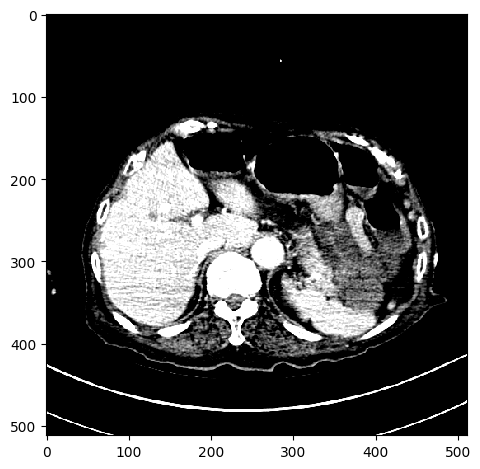

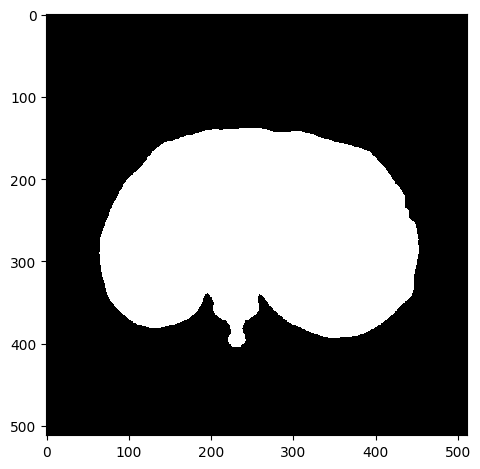

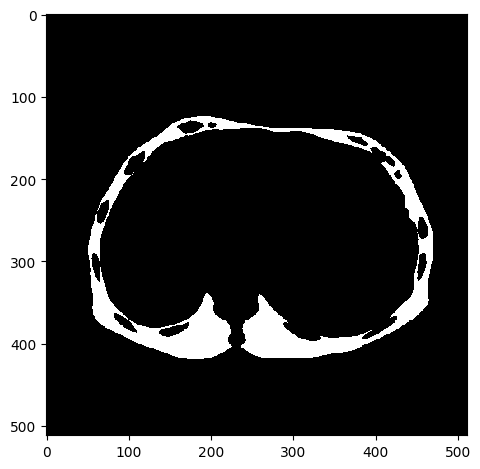

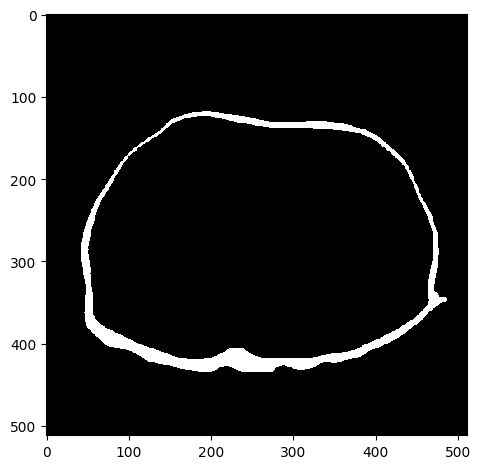

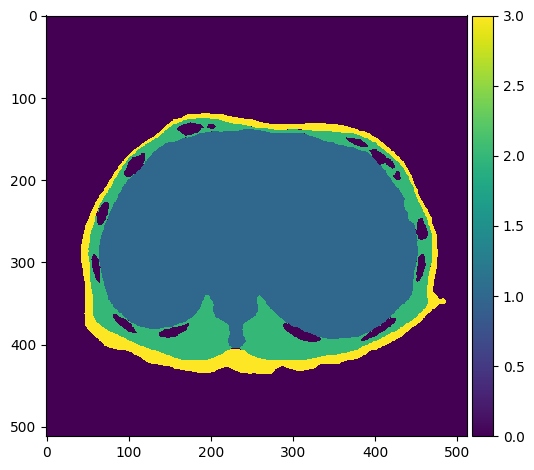

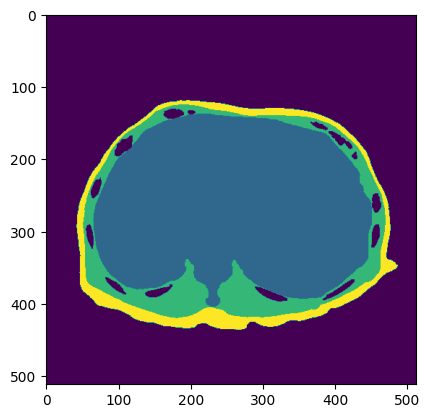

In [153]:
# # To check the prints.

# ix = 16
# print(train_ids[ix])
# path = TRAIN_PATH_IMAGE + train_ids[ix]
# path_label = TRAIN_PATH_MASKS + train_ids[ix].replace('dcm', 'png')

# inp = X_train[ix,:,:,:]
# out = model.predict(np.expand_dims(inp, axis=0))
# # out_t = (out > 0.5).astype(np.uint8) # You can see color. 
# out_t = (out > 0.5).astype(np.float16) # # Black adn white.

# img = read_dicom(path, 160, 50)
# imshow(img)
# plt.show()

# imshow(out_t[0,:,:,0])
# plt.show()
# imshow(out_t[0,:,:,1])
# plt.show()
# imshow(out_t[0,:,:,2])
# plt.show()

# rle = list(prob_to_rles(out_t[0]))

# im = mpimg.imread(path_label)
# im = np.around(im, 8)
# mask_1 = im <= np.around(0.007843138, 8)
# mask_2 = im >= np.around(0.011764706, 8)

# mask_3 = np.logical_and(mask_1, mask_2)
# mask_3
# # im = np.expand_dims(im, axis=-1)
# %matplotlib inline
# imgplot = plt.imshow(im)
# plt.show()

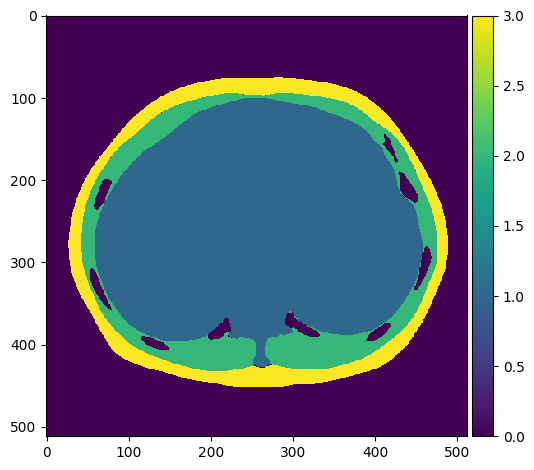

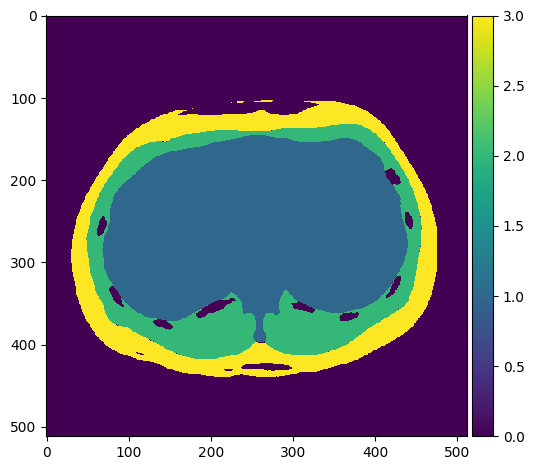

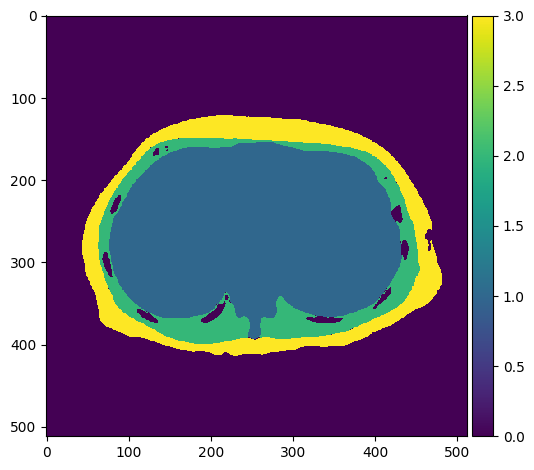

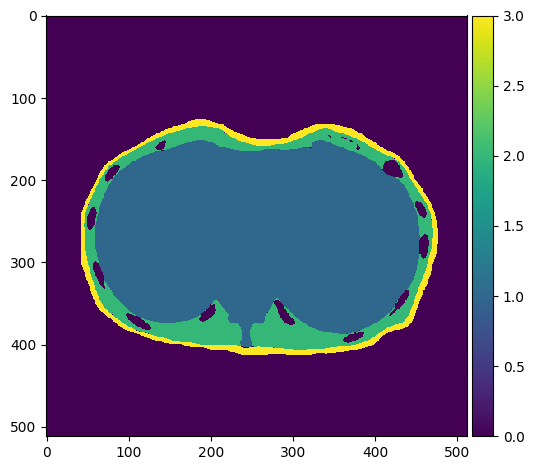

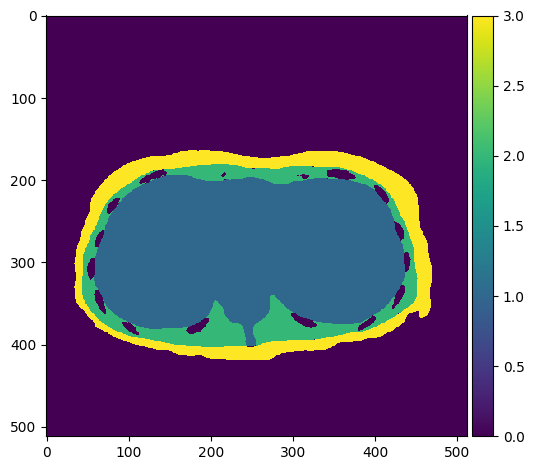

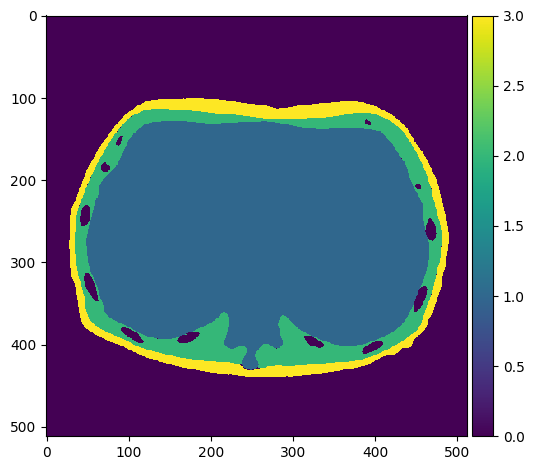

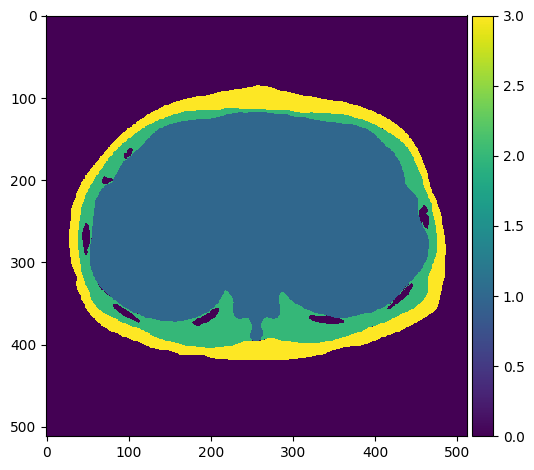

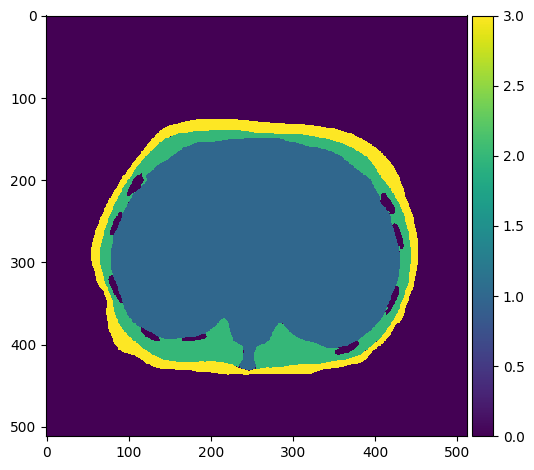

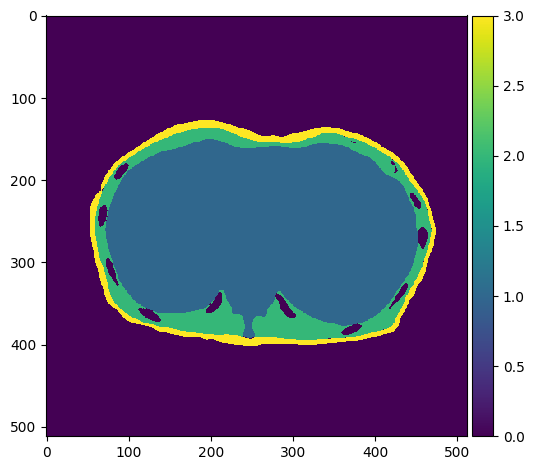

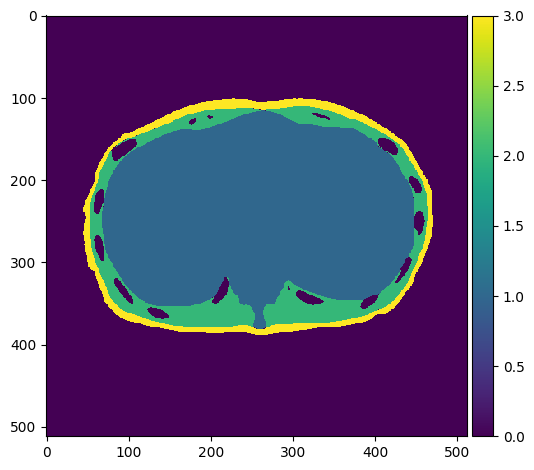

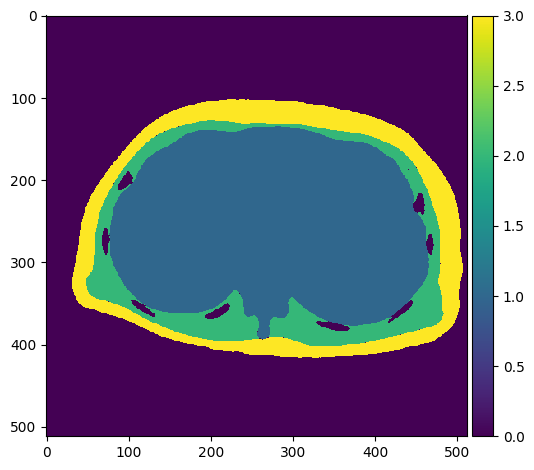

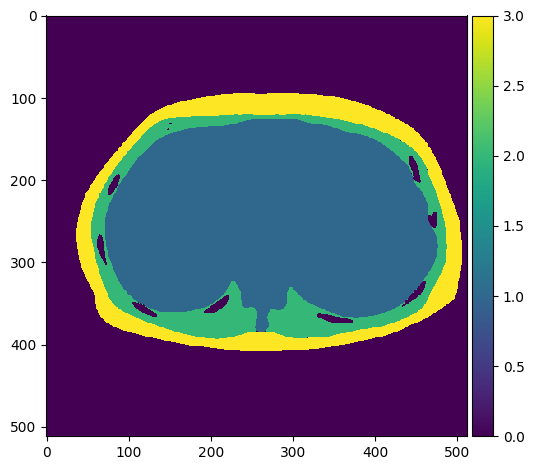

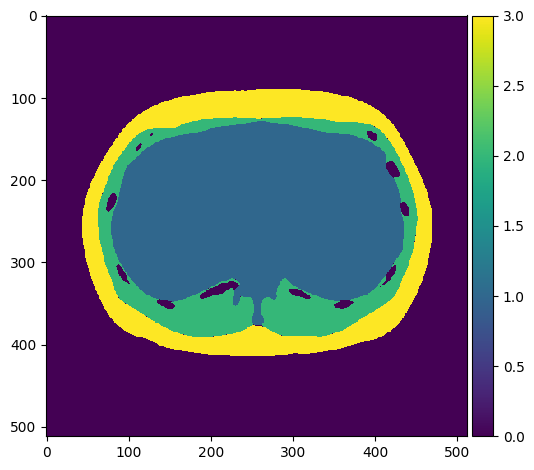

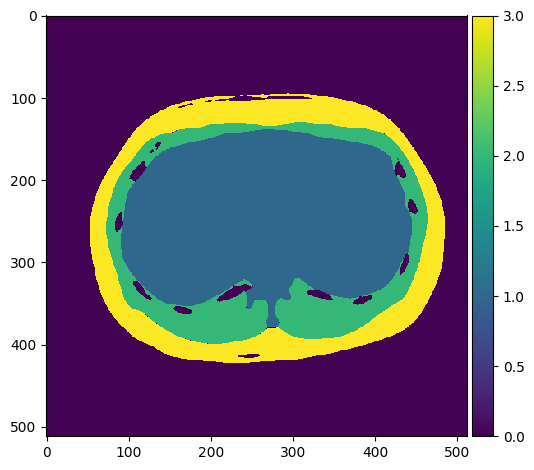

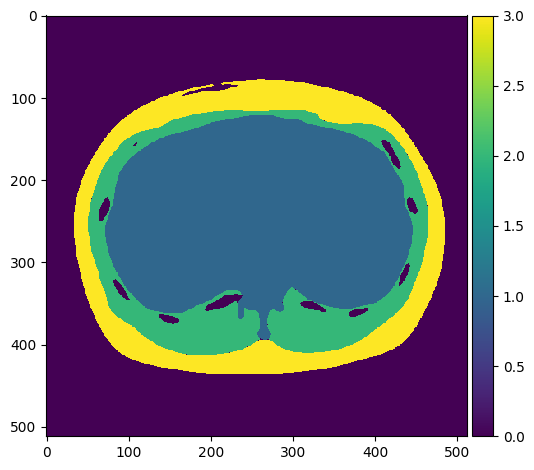

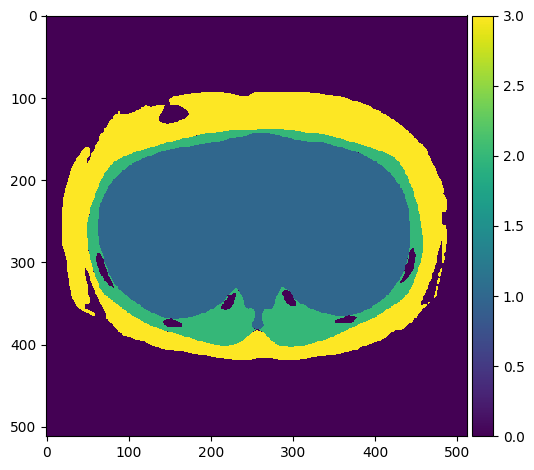

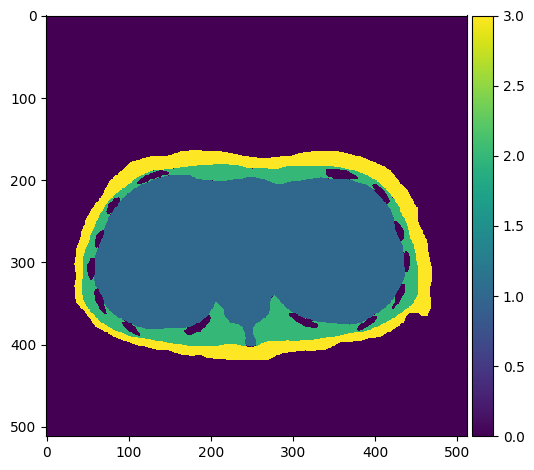

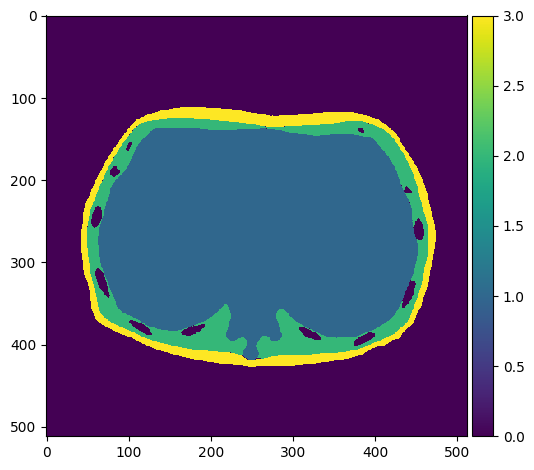

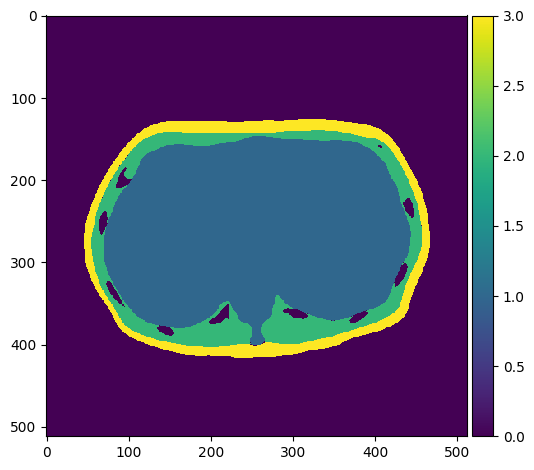

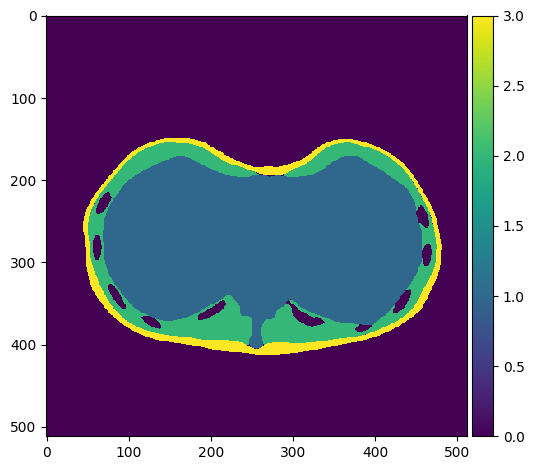

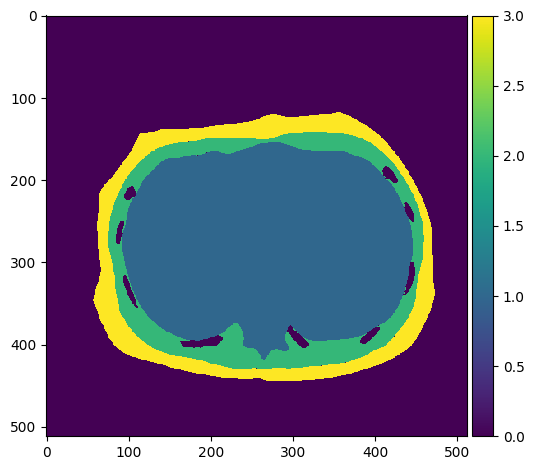

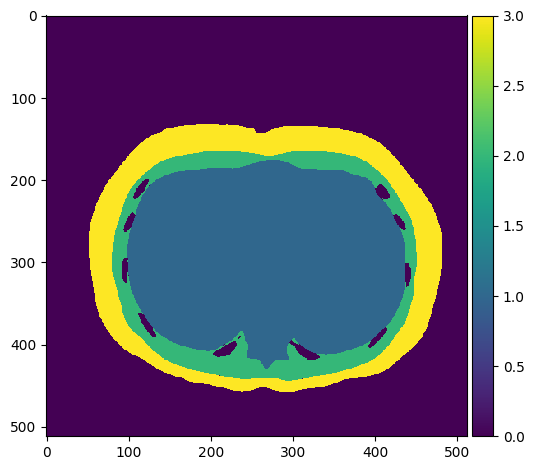

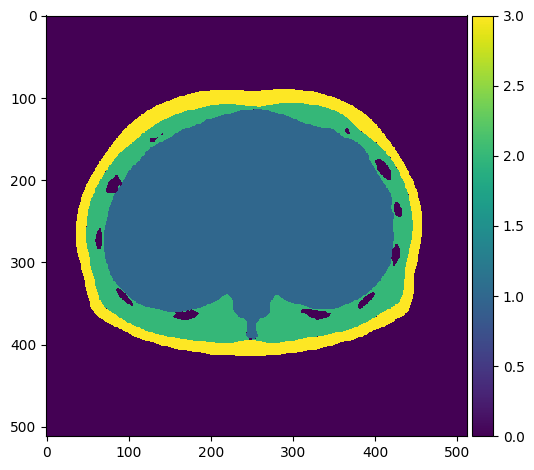

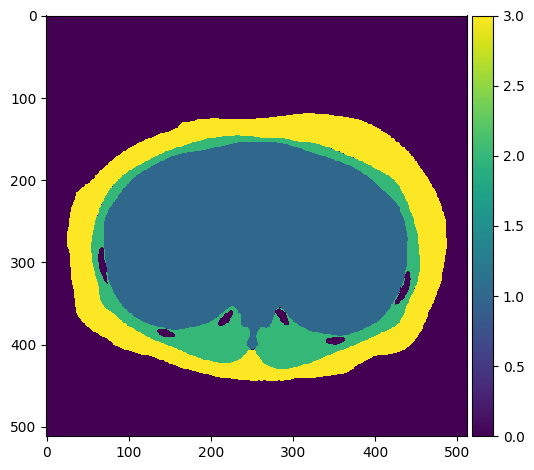

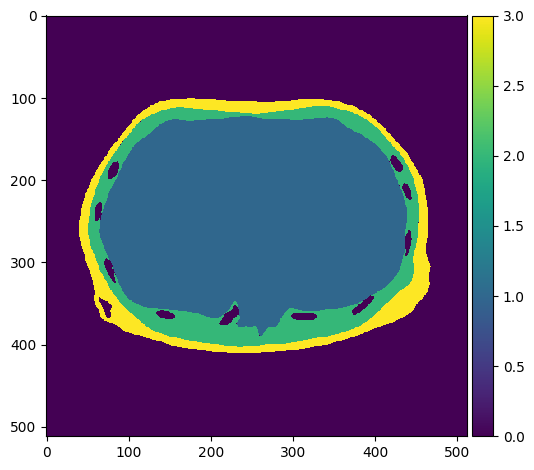

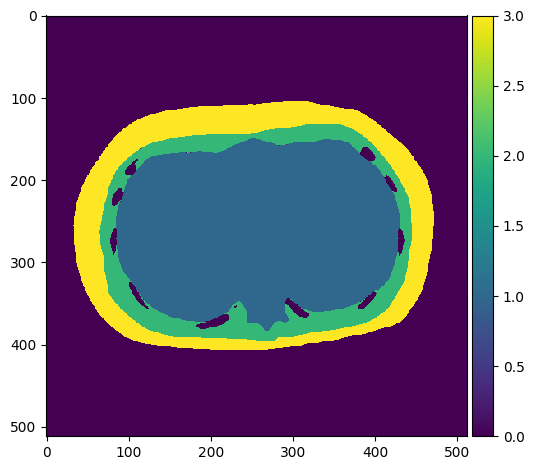

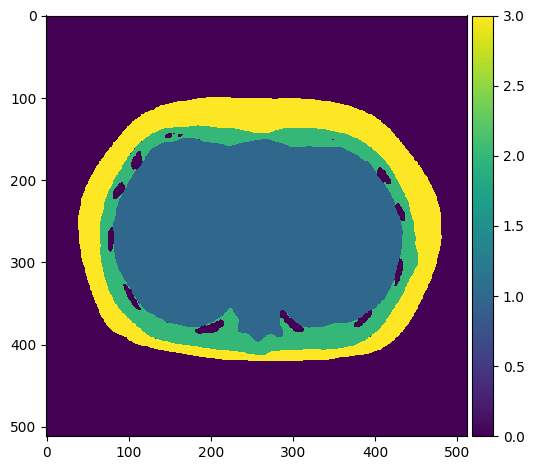

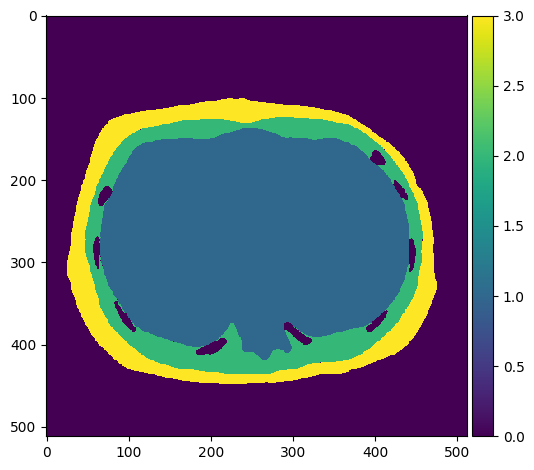

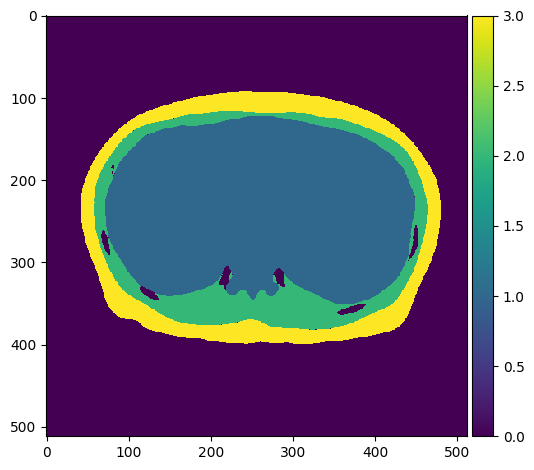

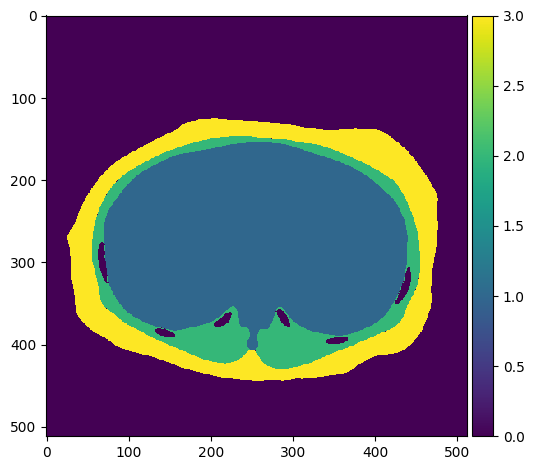

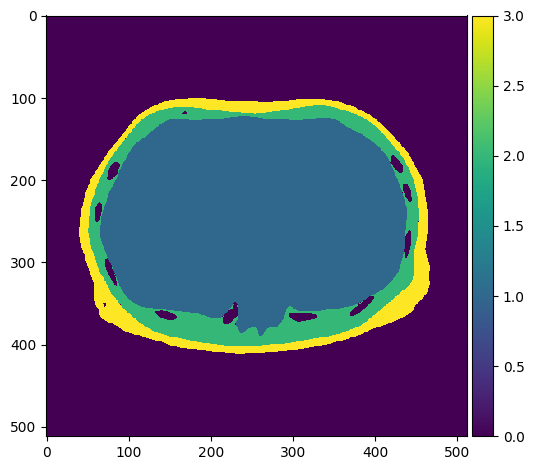

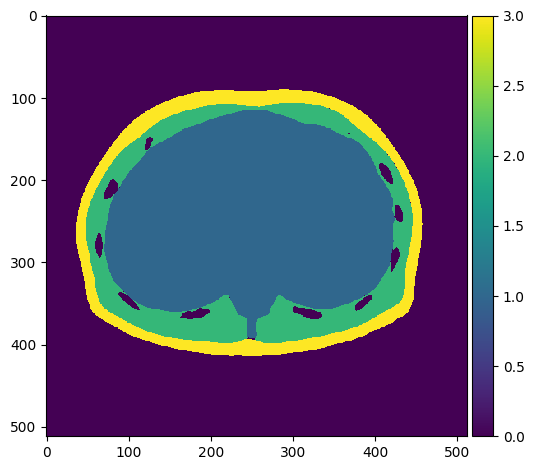

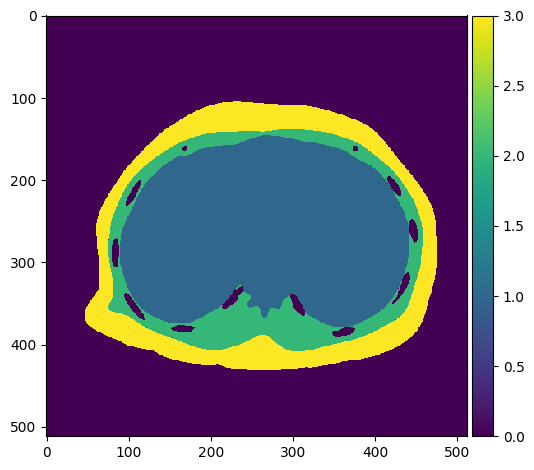

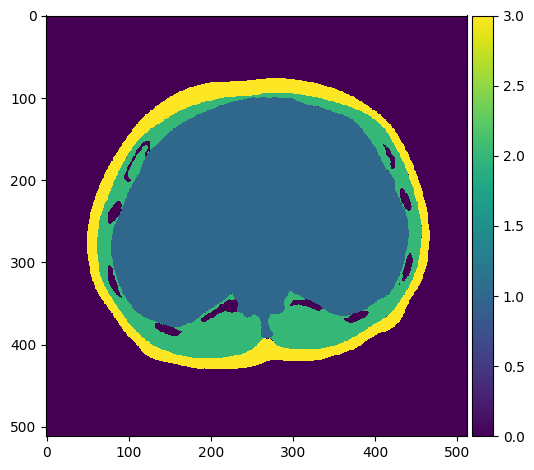

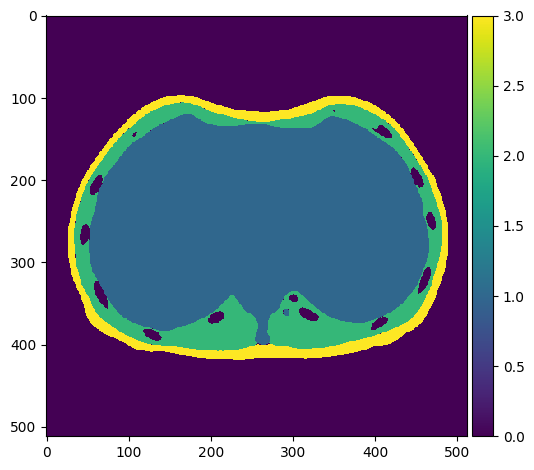

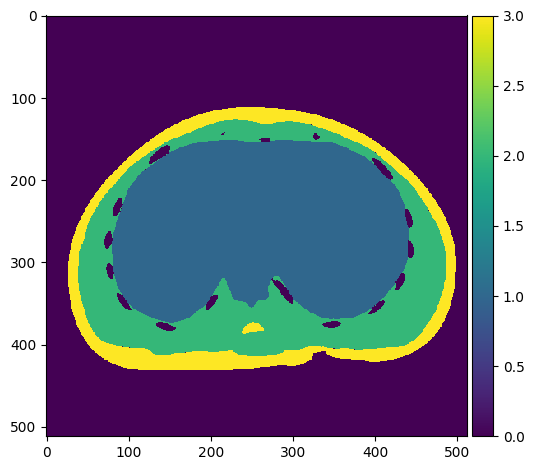

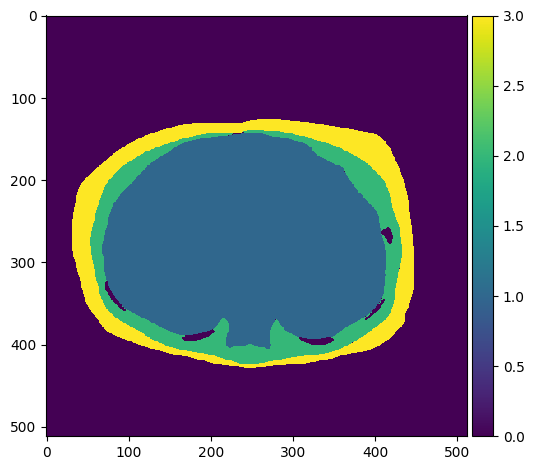

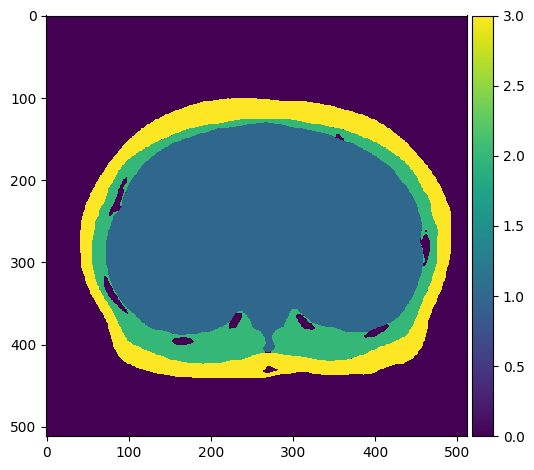

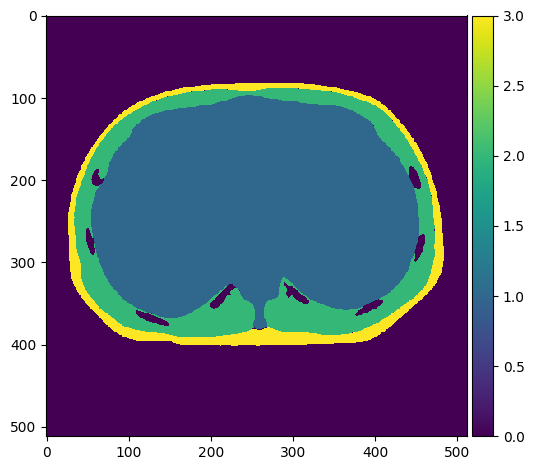

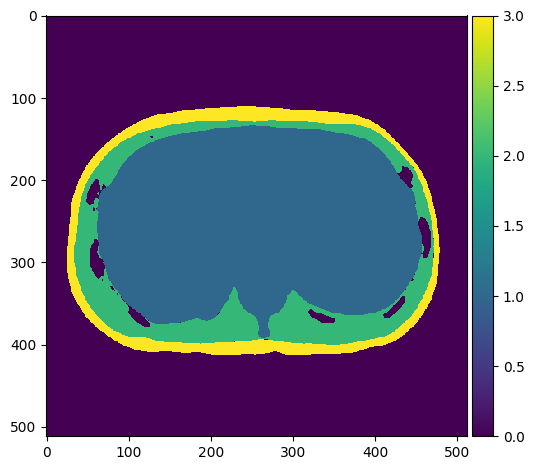

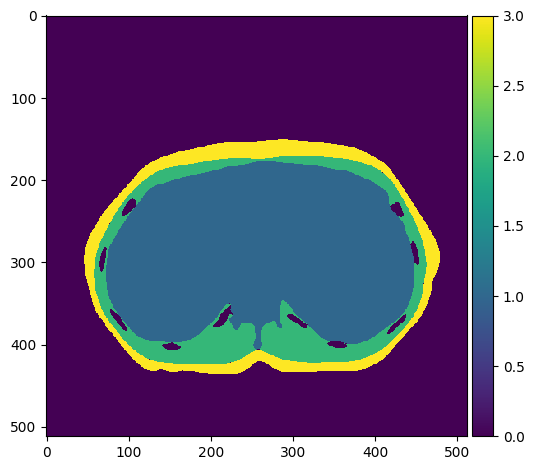

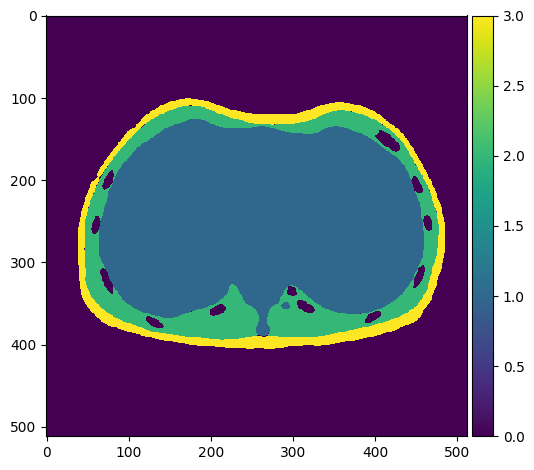

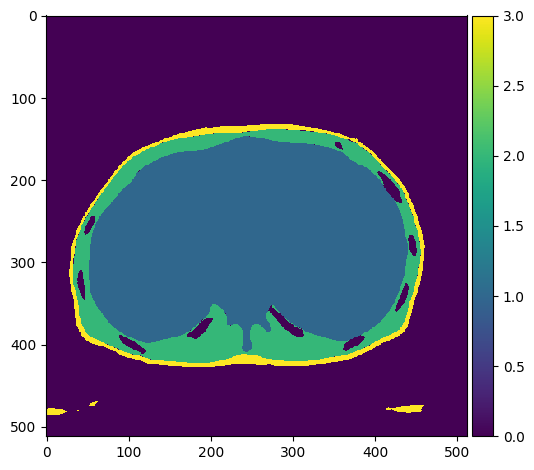

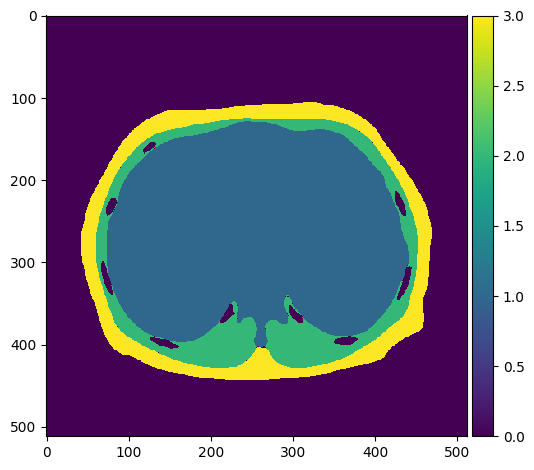

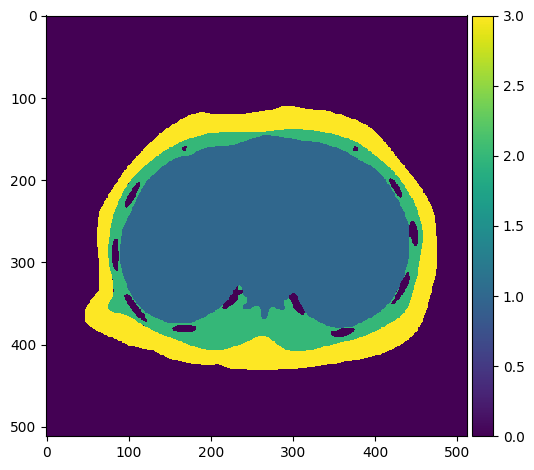

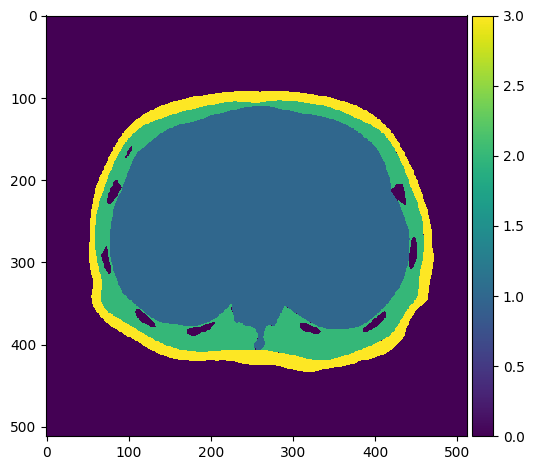

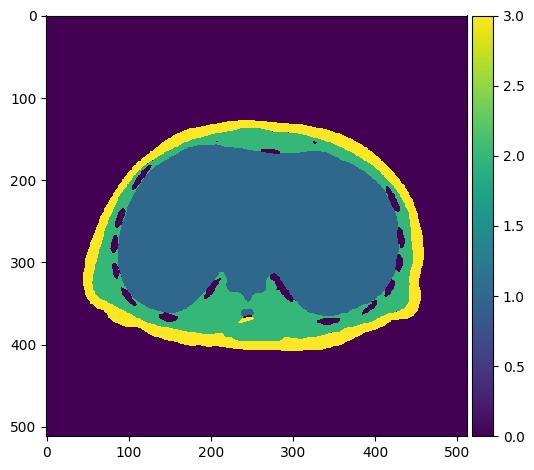

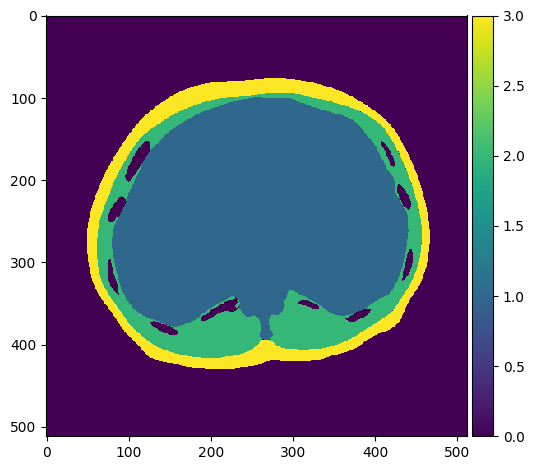

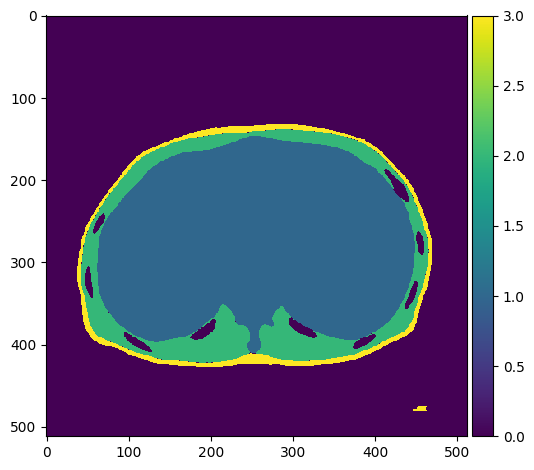

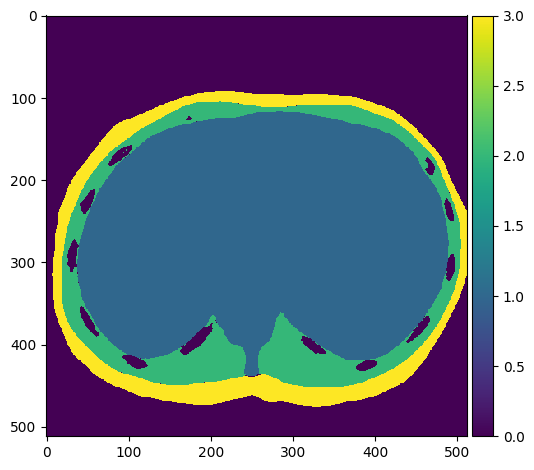

In [145]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_t[n]))
    rles.extend(rle)
    for k in range(len(rle)):
        new_test_ids.extend([id_[:-4] + '_' + str(k+1)])

### Submission

In [146]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)